In [2]:
import data_structures as ds
import importlib
import math
import numpy as np
import os, os.path
import pandas as pd
import pyDOE2 as pyd
import setup_analysis as sa
import support_functions as sf
import time
import warnings
import sys

/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/data_structures.py:1041: UserWarning: Invalid subsector attribute 'key_varreqs_partial'. Valid return type values are:'pycategory_primary', 'abv_subsector', 'sector', 'abv_sector', 'key_varreqs_all'
  warnings.warn(f"Invalid subsector attribute '{return_type}'. Valid return type values are:{valid_rts}")


In [52]:
importlib.reload(sa)
def _setup_logger(namespace: str) -> None:
    global logger
    # configure
    logging.basicConfig(
        filename = "/Users/jsyme/Desktop/tst.log",
        level = logging.DEBUG
    )
    logger = logging.getLogger(namespace)
    # create console handler and set level to debug
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    # create formatter
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    # add formatter to ch
    ch.setFormatter(formatter)
    # add ch to logger
    logger.addHandler(ch)

    return logger

/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/data_structures.py:931: UserWarning: Invalid subsector attribute 'key_varreqs_partial'. Valid return type values are:'pycategory_primary', 'abv_subsector', 'sector', 'abv_sector', 'key_varreqs_all'
  warnings.warn(f"Invalid subsector attribute '{return_type}'. Valid return type values are:{valid_rts}")


In [54]:
logger.info("test")

2022-09-14 13:35:37,874 - INFO - test


In [7]:
# temporary
# expand later to integrate strategy dimension
def build_modvar_input_db_from_templates(
    model_attributes: ds.ModelAttributes,
    sectors: list, 
    region: str, 
    template_type: str,
    repl_missing_with_base: bool = True
) -> pd.DataFrame:
    
    ##  run some checksee
    
    # check region
    region = region.lower()
    if region not in model_attributes.dict_attributes["region"].key_values:
        valid_regions = sf.format_print_list(model_attributes.dict_attributes["region"].key_values)
        raise ValueError(f"Invalid region '{region}' specified. Valid regions are {valid_regions}")
        
    # check sectors
    sectors_drop = [x for x in sectors if (x not in model_attributes.all_sectors)]
    if len(sectors_drop) > 0:
        secs_drop = sf.format_print_list(sectors_drop)
        raise ValueError(f"Invalid sectors {secs_drop} found. Valid sectors are {model_attributes.all_sectors}.")
    
    
    ##
    ##  TEMP: 0 only
    ##
    strat_base = 0
    sheet_base = f"{model_attributes.dim_strategy_id}-{strat_base}"
    
    strats_eval = [strat_base]
    
    df_out = []
    
        
    for sec in sectors:
        fp_templ = sa.excel_template_path(sec, region, template_type, True)
        if not os.path.exists(fp_templ):
            raise ValueError(f"Error: path '{fp_templ}' to template not found.")
        # check available sheets and ensure baseline is available
        sheets_avail = pd.ExcelFile(fp_templ).sheet_names
        if sheet_base not in sheets_avail:
             raise ValueError(f"Baseline strategy sheet {sheet_base} not found in '{fp_templ}'. The template must have a sheet for the baseline strategy.")
        
        
        for strat in strats_eval:
            sheet = f"{model_attributes.dim_strategy_id}-{strat}"
            if not sheet in sheets_avail:
                msg = f"Sheet {sheet} not found in '{fp_templ}'. Check the template."
                if repl_missing_with_base:
                    warnings.warn(f"{msg}. The baseline strategy will be used.")
                    sheet = sheet_base
                else:
                    raise ValueError(msg)
            
            # 
            df_tmp = pd.read_excel(fp_templ, sheet_name = sheet)
            df_tmp[model_attributes.dim_strategy_id] = strat
            
            #
            #   ADD CHECKS FOR TIME PERIODS
            #
            
            
            #
            #   ADD DIFFERENT STEPS FOR NON-BASELINE STRATEGY
            #
            
            if len(df_out) == 0:
                df_out.append(df_tmp)
            else:
                df_out.append(df_tmp[df_out[0].columns])
                
    df_out = pd.concat(df_out, axis = 0).sort_values(by = ["subsector", "variable"]).reset_index(drop = True)
        
    return df_out
        
# function to convert a model variable input database into a simple projection input dataframe
def build_basic_df_from_modvar_inputs(
    model_attributes: ds.ModelAttributes, 
    df_mv: pd.DataFrame
) -> pd.DataFrame:
    """
        build_basic_df_from_modvar_inputs will take a model input database and transform it (under baseline assumptions) into a projection dataframe.

        - model_attributes: a ModelAttributes class

        - df_mv: a dataframe of model variables
    """

    df_mv_out = df_mv[[str(x) for x in model_attributes.get_time_periods()[0]]].transpose().reset_index(drop = True)
    var_fields = list(df_mv["variable"])
    df_mv_out.rename(columns = dict(zip([(x) for x in range(len(df_mv_out.columns))], var_fields)), inplace = True)

    df_mv_out[model_attributes.dim_time_period] = list(range(len(df_mv_out)))
    var_fields.sort()

    return df_mv_out[[model_attributes.dim_time_period] + var_fields]

region = "argentina"
# everything
df_tmp = build_modvar_input_db_from_templates(sa.model_attributes, ["Socioeconomic", "Circular Economy", "AFOLU", "IPPU", "Energy"], region, "demo")       
#df_mv_out = build_basic_df_from_modvar_inputs(sa.model_attributes, df_mv_tmp)


In [275]:
#fp_read = sa.excel_template_path("AFOLU", "argentina", "demo", True)
#pd.read_excel(fp_read, sheet_name = None)
regex_max = re.compile("strategy-(\d*$)")

regex_max.match("strategy-40932")

<re.Match object; span=(0, 14), match='strategy-40932'>

In [284]:
sa.model_attributes.get_baseline_scenario_id("future_id")

ValueError: Invalid dimension 'future_id': valid dimensions are 'time_period', 'strategy_id'.

In [291]:
x = (None, None, None, None, None)
(a, b, c, d, e) = x

all((1, None))

False

In [3]:
df_tmp = pd.read_csv("/Users/jsyme/Documents/Projects/FY20/SWCHE102-1000/git/MultiSector_LTS_Chile/ref/parameter_ranges.csv")
df_tmp0 = df_tmp.copy()
dict_rnm = dict([(str(x), str(x - 2015)) for x in range(2015, 2051)])
dict_rnm.update({"min_2050": "min_35", "max_2050": "max_35", "parameter": "variable", "parameter_constant_q": "uniform_scaling_q"})
df_tmp.rename(columns = dict_rnm, inplace = True)

##  split traj groups
new_col_tg = []
new_col_spec_type = []

for i in range(len(df_tmp)):
    vs = str(df_tmp["variable"].iloc[i])
    tg = None
    spec = None
    
    if "trajgroup" in vs:
        vsplit = vs.split("-")
        tg = int(vsplit[0].split("_")[1])
        check_spec_string = vsplit[1]
    else:
        check_spec_string = vs

    if "trajmax" in check_spec_string:
        spec = "max"
    elif "trajmin" in check_spec_string:
        spec = "min"
    elif "trajmix" in check_spec_string:
        spec = "mix"
    elif "lhs" in (check_spec_string) and (tg != None):
        spec = "lhs"
    
    new_col_tg.append(tg)
    new_col_spec_type.append(spec)
        
df_tmp["variable_trajectory_group"] = pd.Series(new_col_tg, dtype=pd.Int64Dtype())
#df_tmp["trajgroup"] = df_tmp["trajgroup"].astype(int)
df_tmp["variable_trajectory_group_trajectory_type"] = new_col_spec_type


##  update variables
new_tg = max(df_tmp[~df_tmp["variable_trajectory_group"].isna()]["variable_trajectory_group"]) + 1
tgs = list(df_tmp["variable_trajectory_group"].copy())
tgspecs = list(df_tmp["variable_trajectory_group_trajectory_type"].copy())
var_list = list(df_tmp["variable"].copy())
dict_parameter_to_tg = {}
dict_repl_tgt = {"max": "trajectory_boundary_1", "min": "trajectory_boundary_0"}

for i in range(len(df_tmp)):
    tg = str(df_tmp["variable_trajectory_group"].iloc[i])
    tgspec = str(df_tmp["variable_trajectory_group_trajectory_type"].iloc[i])
    vs = str(df_tmp["variable"].iloc[i])
    
    if (tgspec != "<NA>") & (tgspec != "None"):
        if tg not in ["<NA>", "None"]:
            # drop the group/remove the trajmax/min/mix
            vs = vs.split("-")[1]
            new_tg_q = False
        else:
            new_tg_q = True
        
        # check for current trajgroup type
        for lev in ["max", "mix", "min"]:
            str_check = f"traj{lev}_"
            if str_check in vs:
                vs = vs.replace(str_check, "")
                
        # update the variable list
        var_list[i] = vs
        # update indexing of trajectory groups
        if new_tg_q:
            if vs in dict_parameter_to_tg.keys():
                tgs[i] = int(dict_parameter_to_tg[vs])
            else:
                dict_parameter_to_tg.update({vs: new_tg})
                tgs[i] = new_tg
                new_tg += 1

df_tmp["variable"] = var_list
df_tmp["variable_trajectory_group"] = tgs
df_tmp = df_tmp[~df_tmp["variable"].isin(["lhs"])]
df_tmp["variable_trajectory_group_trajectory_type"].replace(dict_repl_tgt, inplace = True)



In [251]:
import re
regex1 = re.compile("(\d*$)")
regex1.match("09")



<re.Match object; span=(0, 2), match='09'>

In [66]:
strr = re.compile(f"{sa.model_attributes.dim_strategy_id}-(.*\d$)")
strr.match("strategy_id-0").groups()[0]

'0'

In [449]:
##  class for sampling and generating experimental design
class sampling_unit:

    def __init__(self, df_var_def: pd.core.frame.DataFrame, dict_baseline_ids: dict, time_period_u0: int, field_strategy_id: str = "strategy_id", fan_function_specification: str = "linear"):

        # set some attributes

        self.field_strategy_id = field_strategy_id
        self.time_period_end_certainty = time_period_u0
        df_var = self.check_input_data_frame(df_var_def)
        self.fields_id = self.get_id_fields(df_var)
        self.field_min_scalar, self.field_max_scalar, self.time_period_scalar = self.get_scalar_time_period(df_var)
        self.fields_time_periods, self.time_periods = self.get_time_periods(df_var)
        self.variable_trajectory_group = self.get_trajgroup(df_var)
        self.uncertainty_fan_function_parameters = self.get_fan_function_parameters(fan_function_specification)
        self.uncertainty_ramp_vector = self.build_ramp_vector(self.uncertainty_fan_function_parameters)
        
        self.data_table, self.id_coordinates = self.check_scenario_variables(df_var, self.fields_id)
        self.dict_id_values, self.dict_baseline_ids = self.get_scenario_values(self.data_table, self.fields_id, dict_baseline_ids)
        self.num_scenarios = len(self.id_coordinates)
        self.variable_specifications = self.get_all_vs(self.data_table )
        self.dict_variable_info = self.get_variable_dictionary(self.data_table, self.fields_id, self.fields_time_periods, self.variable_specifications, self.field_max_scalar, self.field_min_scalar)
        self.ordered_trajectory_arrays = self.get_ordered_trajectory_arrays(self.data_table, self.fields_id, self.fields_time_periods, self.variable_specifications)
        self.scalar_diff_arrays = self.get_scalar_diff_arrays()
        
        # important components for different design ids + assessing uncertainty in lever acheivement
        self.fields_order_strat_diffs = [x for x in self.fields_id if (x != self.field_strategy_id)] + [self.field_var_spec, self.field_trajgroup_spec]
        self.xl_type, self.dict_strategy_info = self.infer_sampling_unit_type()

        

    # initialize some attributes
    field_trajgroup = "variable_trajectory_group"
    field_trajgroup_spec = "variable_trajectory_group_trajectory_type"
    field_uniform_scaling_q = "uniform_scaling_q"
    field_var_spec = "variable"
    # maps internal name (key) to classification in the input data frame (value)
    dict_required_tg_spec_fields = {"mixing_trajectory": "mix", "trajectory_boundary_0": "trajectory_boundary_0", "trajectory_boundary_1": "trajectory_boundary_1"}
    required_tg_specs = list(dict_required_tg_spec_fields.values())#[dict_required_tg_spec_fields[x] for x in ["mixing_trajectory", "boundary_trajectory_0", "boundary_trajectory_1"]]


    ##  functions to initialize attributes

    def check_input_data_frame(self, df_in: pd.DataFrame):

        # some standardized fields to require
        fields_req = [self.field_strategy_id, self.field_trajgroup, self.field_trajgroup_spec, self.field_uniform_scaling_q, self.field_var_spec]
        if len(set(fields_req) & set(df_in.columns)) < len(set(fields_req)):
            fields_missing = list(set(fields_req) - (set(fields_req) & set(df_in.columns)))
            fields_missing.sort()
            str_missing = ", ".join([f"'{x}'" for x in fields_missing])
            raise ValueError(f"Error: one or more columns are missing from the data frame. Columns {str_missing} not found")
        elif (self.field_strategy_id in df_in.columns) and ("_id" not in self.field_strategy_id):
            raise ValueError(f"Error: the strategy field '{self.field_strategy_id}' must contain the substring '_id'. Check to ensure this substring is specified.")

        return df_in.drop_duplicates()


    def check_scenario_variables(self, df_in: pd.DataFrame, fields_id: list):
        tups_id = set([tuple(x) for x in np.array(df_in[fields_id])])
        for tg_type in self.required_tg_specs:
            df_check = df_in[df_in[self.field_trajgroup_spec] == tg_type]
            for vs in list(df_check[self.field_var_spec].unique()):
                tups_id = tups_id & set([tuple(x) for x in np.array(df_check[df_check[self.field_var_spec] == vs][fields_id])])
        df_scen = pd.DataFrame(tups_id, columns = fields_id)
        df_in = pd.merge(df_in, df_scen, how = "inner", on = fields_id)

        return (df_in, tups_id)


    def get_all_vs(self, df_in: pd.DataFrame):
        if not self.field_var_spec in df_in.columns:
            raise ValueError(f"Field '{self.field_var_spec}' not found in data frame.")
        all_vs = list(df_in[self.field_var_spec].unique())
        all_vs.sort()
        return all_vs


    def get_id_fields(self, df_in: pd.DataFrame):
        fields_out = [x for x in df_in.columns if ("_id" in x)]
        fields_out.sort()
        if len(fields_out) == 0:
            raise ValueError(f"No id fields found in data frame.")

        return fields_out


    def get_ordered_trajectory_arrays(self, df_in: pd.DataFrame, fields_id: list, fields_time_periods: list, variable_specifications: list):
        # order trajectory arrays by id fields; used for quicker lhs application across id dimensions
        dict_out = {}
        for vs in variable_specifications:
            df_cur_vs = df_in[df_in[self.field_var_spec].isin([vs])].sort_values(by = fields_id)

            if self.variable_trajectory_group == None:
                dict_out.update({(vs, None): {"data": np.array(df_cur_vs[fields_time_periods]), "id_coordinates": df_cur_vs[fields_id]}})
            else:
                for tgs in self.required_tg_specs:
                    df_cur = df_cur_vs[df_cur_vs[self.field_trajgroup_spec] == tgs]
                    dict_out.update({(vs, tgs): {"data": np.array(df_cur[fields_time_periods]), "id_coordinates": df_cur[fields_id]}})
        return dict_out


    def get_scalar_time_period(self, df_in:pd.DataFrame):
        # determine min field/time period
        field_min = [x for x in df_in.columns if "min" in x]
        if len(field_min) == 0:
            raise ValueError("No field associated with a minimum scalar value found in data frame.")
        else:
            field_min = field_min[0]

        # determine max field/time period
        field_max = [x for x in df_in.columns if "max" in x]
        if len(field_max) == 0:
            raise ValueError("No field associated with a maximum scalar value found in data frame.")
        else:
            field_max = field_max[0]

        tp_min = int(field_min.split("_")[1])
        tp_max = int(field_max.split("_")[1])
        if (tp_min != tp_max) | (tp_min == None):
            raise ValueError(f"Fields '{tp_min}' and '{tp_max}' imply asymmetric final time periods.")
        else:
            tp_out = tp_min

        return (field_min, field_max, tp_out)


    def get_scenario_values(self, df_in: pd.DataFrame, fields_id: list, dict_baseline_ids: dict):
        # get scenario index values by scenario dimension
        dict_id_values = {}
        dict_id_baselines = dict_baseline_ids.copy()

        for fld in fields_id:
            dict_id_values.update({fld: list(df_in[fld].unique())})
            dict_id_values[fld].sort()

            # check if baseline for field is determined
            if fld in dict_id_baselines.keys():
                bv = int(dict_id_baselines[fld])

                if bv not in dict_id_values[fld]:
                    if fld == self.field_strategy_id:
                        print(bv)
                        raise ValueError(f"Error: baseline {self.field_strategy_id} scenario index '{bv}' not found in the variable trajectory input sheet. Please ensure the basline strategy is specified correctly.")
                    else:
                        msg_warning = f"The baseline id for dimension {fld} not found. The experimental design will not include futures along this dimension of analysis."
                        warnings.warn(msg_warning)
            else:
                # assume minimum >= 0
                bv = min([x for x in dict_id_values[fld] if x >= 0])
                dict_id_baselines.update({fld: bv})
                msg_warning = f"No baseline scenario index found for {fld}. It will be assigned to '{bv}', the lowest non-negative integer."
                warnings.warn(msg_warning)


        return dict_id_values, dict_id_baselines


    def get_time_periods(self, df_in: pd.DataFrame):
        fields_time_periods = [x for x in df_in.columns if x.isnumeric()]
        fields_time_periods = [x for x in fields_time_periods if int(x) == float(x)]
        if len(fields_time_periods) == 0:
            raise ValueError("No time periods found in data frame.")
        else:
            time_periods = [int(x) for x in fields_time_periods]

        time_periods.sort()
        fields_time_periods = [str(x) for x in time_periods]

        return (fields_time_periods, time_periods)

    # get the trajectory group for the sampling unit
    def get_trajgroup(self, df_in: pd.DataFrame):
        if not self.field_trajgroup in df_in.columns:
            raise ValueError(f"Field '{self.field_trajgroup}' not found in data frame.")
        # determine if this is associated with a trajectory group
        if len(df_in[~df_in[self.field_trajgroup].isna()]) > 0:
            return int(list(df_in[self.field_trajgroup].unique())[0])
        else:
            return None

    # the variable dictionary includes information on sampling ranges for time period scalars, wether the variables should be scaled uniformly, and the trajectories themselves
    def get_variable_dictionary(
        self, 
        df_in: pd.DataFrame, 
        fields_id: list, 
        fields_time_periods: list,
        variable_specifications: list,
        field_max: str,
        field_min: str
    ):
        dict_var_info = {}

        if self.variable_trajectory_group != None:
            tgs_loops = self.required_tg_specs
        else:
            tgs_loops = [None]

        for vs in variable_specifications:
            for tgs in tgs_loops:
                if tgs == None:
                    df_cur = sf.subset_df(df_in, {self.field_var_spec: vs})
                else:
                    df_cur = sf.subset_df(df_in, {self.field_var_spec: vs, self.field_trajgroup_spec: tgs})
                    
                dict_vs = {
                    "max_scalar": sf.build_dict(df_cur[fields_id + [field_max]]),
                    "min_scalar": sf.build_dict(df_cur[fields_id + [field_min]]),
                    "uniform_scaling_q": sf.build_dict(df_cur[fields_id + [self.field_uniform_scaling_q]]),
                    "trajectories": sf.build_dict(df_cur[fields_id + fields_time_periods], (len(self.fields_id), len(self.fields_time_periods)))}

                dict_var_info.update({(vs, tgs): dict_vs})

        return dict_var_info

    # determine if the sampling unit represents a strategy (L) or an uncertainty (X)
    def infer_sampling_unit_type(self, thresh: float = (10**(-12))):
        fields_id_no_strat = [x for x in self.fields_id if (x != self.field_strategy_id)]

        strat_base = self.dict_baseline_ids[self.field_strategy_id]
        strats_not_base = [x for x in self.dict_id_values[self.field_strategy_id] if (x != strat_base)]
        fields_ext = [self.field_var_spec, self.field_trajgroup_spec] + self.fields_id + self.fields_time_periods
        fields_ext = [x for x in fields_ext if (x != self.field_strategy_id)]
        fields_merge = [x for x in fields_ext if (x not in self.fields_time_periods)]
        # get the baseline strategy specification + set a renaming dictionary for merges
        df_base = self.data_table[self.data_table[self.field_strategy_id] == strat_base][fields_ext].sort_values(by = self.fields_order_strat_diffs).reset_index(drop = True)
        arr_base = np.array(df_base[self.fields_time_periods])
        fields_base = list(df_base.columns)

        dict_out = {
            "baseline_strategy_data_table": df_base, 
            "baseline_strategy_array": arr_base,
            "difference_arrays_by_strategy": {}
        }

        dict_diffs = {}
        strategy_q = False

        for strat in strats_not_base:

            df_base = pd.merge(df_base, self.data_table[self.data_table[self.field_strategy_id] == strat][fields_ext], how = "inner", on = fields_merge, suffixes = (None, "_y"))
            df_base.sort_values(by = self.fields_order_strat_diffs, inplace = True)
            arr_cur = np.array(df_base[[(x + "_y") for x in self.fields_time_periods]])
            arr_diff = arr_cur - arr_base
            dict_diffs.update({strat: arr_diff})
            df_base = df_base[fields_base]

            if max(np.abs(arr_diff.flatten())) > thresh:
                strategy_q = True

        if strategy_q:
            dict_out.update({"difference_arrays_by_strategy": dict_diffs})
            type_out = "L"
        else:
            type_out = "X"

        return type_out, dict_out




    ##  operational functions

    def get_scalar_diff_arrays(self):

        tp_end = self.fields_time_periods[-1]
        dict_out = {}

        for vs in self.variable_specifications:
            if self.variable_trajectory_group != None:
                tgs_loops = self.required_tg_specs
            else:
                tgs_loops = [None]
            for tgs in tgs_loops:
                # get the vector (dim is by scenario, sorted by self.fields_id )
                vec_tp_end = self.ordered_trajectory_arrays[(vs, tgs)]["data"][:,-1]
                tups_id_coords = [tuple(x) for x in np.array(self.ordered_trajectory_arrays[(vs, tgs)]["id_coordinates"])]
                # order the max/min scalars
                vec_scale_max = np.array([self.dict_variable_info[(vs, tgs)]["max_scalar"][x] for x in tups_id_coords])
                vec_scale_min = np.array([self.dict_variable_info[(vs, tgs)]["min_scalar"][x] for x in tups_id_coords])

                # difference, in final time period, between scaled value and baseline value-dimension is # of scenarios
                dict_tp_end_delta = {
                    "max_tp_end_delta": vec_tp_end*(vec_scale_max - 1),
                    "min_tp_end_delta": vec_tp_end*(vec_scale_min - 1)
                }

                dict_out.update({(vs, tgs): dict_tp_end_delta})

        return dict_out
    
    
    def mix_tensors(self, vec_b0, vec_b1, vec_mix, constraints_mix: tuple = (0, 1)):

        v_0 = np.array(vec_b0)
        v_1 = np.array(vec_b1)
        v_m = np.array(vec_mix)


        if constraints_mix != None:
            if constraints_mix[0] >= constraints_mix[1]:
                raise ValueError("Constraints to the mixing vector should be passed as (min, max)")
            v_alpha = v_m.clip(*constraints_mix)
        else:
            v_alpha = np.array(vec_mix)

        if len(v_alpha.shape) == 0:
            v_alpha = float(v_alpha)
            check_val = len(set([v_0.shape, v_1.shape]))
        else:
            check_val = len(set([v_0.shape, v_1.shape, v_alpha.shape]))

        if check_val > 1:
            raise ValueError("Incongruent shapes in mix_tensors")

        return v_0*(1 - v_alpha) + v_1*v_alpha

    
    def ordered_by_ota_from_fid_dict(self, dict_in: dict, key_tuple: tuple):
        return np.array([dict_in[tuple(x)] for x in np.array(self.ordered_trajectory_arrays[key_tuple]["id_coordinates"])])




    ## uncertainty fan functions
    
     # construct the "ramp" vector for uncertainties
    def build_ramp_vector(self, tuple_param):

        if tuple_param == None:
            tuple_param = self.get_f_fan_function_parameter_defaults(self.uncertainty_fan_function_type)

        if len(tuple_param) == 4:
            tp_0 = self.time_period_end_certainty
            n = len(self.time_periods) - tp_0 - 1

            return np.array([int(i > tp_0)*self.f_fan(i - tp_0 , n, *tuple_param) for i in range(len(self.time_periods))])
        else:
            raise ValueError(f"Error: tuple_param {tuple_param} in build_ramp_vector has invalid length. It should have 4 parameters.")

    # basic function that determines the shape; based on a generalization of the sigmoid (includes linear option)
    def f_fan(self, x, n, a, b, c, d):
        """
         *defaults*
        
         for linear: 
            set a = 0, b = 2, c = 1, d = n/2 
         for sigmoid:
            set a = 1, b = 0, c = math.e, d = n/2
        
        
        """
        return (a*n + b*x)/(n*(1 + c**(d - x)))

    # parameter defaults for the fan, based on the number of periods n
    def get_f_fan_function_parameter_defaults(self, n: int, fan_type: str, return_type: str = "params"):
        dict_ret = {
            "linear": (0, 2, 1, n/2),
            "sigmoid": (1, 0, math.e, n/2)
        }

        if return_type == "params":
            return dict_ret[fan_type]
        elif return_type == "keys":
            return list(dict_ret.keys())
        else:
            str_avail_keys = ", ".join(list(dict_ret.keys()))
            raise ValueError(f"Error: invalid return_type '{return_type}'. Ensure it is one of the following: {str_avail_keys}.")

    # verify fan function parameters
    def get_fan_function_parameters(self, fan_type):
        
        if type(fan_type) == str:
            n = len(self.time_periods) - self.time_period_end_certainty
            keys = self.get_f_fan_function_parameter_defaults(n, fan_type, "keys")
            if fan_type in keys:
                return self.get_f_fan_function_parameter_defaults(n, fan_type, "params")
            else:
                str_avail_keys = ", ".join(keys)
                raise ValueError(f"Error: no defaults specified for uncertainty fan function of type {fan_type}. Use a default or specify parameters a, b, c, and d. Default functional parameters are available for each of the following: {str_avail_keys}")
        elif type(fan_type) == tuple:
            if len(fan_type) == 4:
                if set([type(x) for x in fan_type]).issubset({int, float}):
                    return fan_type
                else:
                    raise ValueError(f"Error: fan parameter specification {fan_type} contains invalid parameters. Ensure they are numeric (int or float)")
            else:
                raise ValueError(f"Error: fan parameter specification {fan_type} invalid. 4 Parameters are required.")
            
   

    def build_futures(self, n_samples: int, random_seed: int):
        print(f"sampling {self.id_values}")

        
    def generate_future(self, lhs_trial: float, lhs_trial_design: float = 1.0, constraints_mix_tg: tuple = (0, 1), baseline_future_q: bool = False):
        
        # index by variable_specification at keys
        dict_out = {}
        
        if not self.variable_trajectory_group == None:
            
            #list(set([x[0] for x in self.ordered_trajectory_arrays.keys()]))
            cat_mix = self.dict_required_tg_spec_fields["mixing_trajectory"]
            cat_b0 = self.dict_required_tg_spec_fields["trajectory_boundary_0"]
            cat_b1 = self.dict_required_tg_spec_fields["trajectory_boundary_1"]

            #if self.xl_type == "x":

            # use mix between 0/1 (0 = 100% trajectory_boundary_0, 1 = 100% trajectory_boundary_1)
            for vs in self.variable_specifications:
                
                dict_arrs = {
                    cat_b0: self.ordered_trajectory_arrays[(vs, cat_b0)]["data"],
                    cat_b1: self.ordered_trajectory_arrays[(vs, cat_b1)]["data"],
                    cat_mix: self.ordered_trajectory_arrays[(vs, cat_mix)]["data"]
                }


                if (baseline_future_q):
                    # for trajectory groups, the baseline is the specified mixing vector
                    arr_out = self.mix_tensors(dict_arrs[cat_b0], dict_arrs[cat_b1], dict_arrs[cat_mix], constraints_mix_tg)
                else:
                    arr_out = self.mix_tensors(dict_arrs[cat_b0], dict_arrs[cat_b1], lhs_trial, constraints_mix_tg)

                if self.xl_type == "L":
                    
                    if lhs_trial_design < 0:
                        raise ValueError(f"The value of lhs_trial_design = {lhs_trial_design} is invalid. lhs_trial_design must be >= 0.")
                    #
                    # if the XL is an L, then we use the modified future as a base (reduce to include only baseline strategy), then add the uncertainty around the strategy effect
                    #
                    
                    n_strat = len(self.dict_id_values[self.field_strategy_id])
                    # get id coordinates( any of cat_mix, cat_b0, or cat_b1 would work -- use cat_mix)
                    df_ids_ota = pd.concat([self.ordered_trajectory_arrays[(vs, cat_mix)]["id_coordinates"].copy().reset_index(drop = True), pd.DataFrame(arr_out, columns = self.fields_time_periods)], axis = 1)
                    w = np.where(df_ids_ota[self.field_strategy_id] == self.dict_baseline_ids[self.field_strategy_id])
                    df_ids_ota = df_ids_ota.iloc[w[0].repeat(n_strat)].reset_index(drop = True)
                    arr_out = np.array(df_ids_ota[self.fields_time_periods])
                    
                    l_modified_cats = []
                    inds0 = set(np.where(self.dict_strategy_info["baseline_strategy_data_table"][self.field_var_spec] == vs)[0])
                    
                    for cat_cur in [cat_b0, cat_b1, cat_mix]:
                        
                        # get the index for the current vs/cat_cur
                        inds = np.sort(np.array(list(inds0 & set(np.where(self.dict_strategy_info["baseline_strategy_data_table"][self.field_trajgroup_spec] == cat_cur)[0]))))
                        n_inds = len(inds)
                        df_ids0 = self.dict_strategy_info["baseline_strategy_data_table"][[x for x in self.fields_id if (x != self.field_strategy_id)]].loc[inds.repeat(n_strat)].reset_index(drop = True)
                        new_strats = list(np.zeros(len(df_ids0)).astype(int))
                        
                        # initialize as list - we only do this to guarantee the sort is correct
                        df_future_strat = np.zeros((n_inds*len(self.dict_id_values[self.field_strategy_id]), len(self.fields_time_periods)))
                        ind_repl = 0
                        
                        ##  start loop
                        for strat in self.dict_id_values[self.field_strategy_id]:

                            # strategy ids
                            new_strats[ind_repl*n_inds:((ind_repl + 1)*n_inds)] = [strat for x in inds]

                            # get the strategy difference that is adjusted by lhs_trial_delta; if baseline strategy, use 0s
                            df_repl = np.zeros((n_inds, len(self.fields_time_periods))) if (strat == self.dict_baseline_ids[self.field_strategy_id]) else self.dict_strategy_info["difference_arrays_by_strategy"][strat][inds, :]*lhs_trial_design
                            #df_repl = pd.concat([df_ids.reset_index(drop = True), pd.DataFrame(df_repl, columns = self.fields_time_periods)], axis = 1)
                            #df_repl = pd.DataFrame(df_repl, columns = self.fields_time_periods)
                            
                            np.put(df_future_strat, range(n_inds*len(self.fields_time_periods)*ind_repl, n_inds*len(self.fields_time_periods)*(ind_repl + 1)), df_repl)
                            
                            #if init_q:
                            #    df_future_strat = [df_repl for x in self.dict_id_values[self.field_strategy_id]]
                            #    init_q = False
                            #else:
                            #    df_future_strat[ind_repl] = df_repl

                            ind_repl += 1

                        #df_future_strat = pd.concat(df_future_strat, axis = 0).reset_index(drop = True)
                        df_ids0[self.field_strategy_id] = new_strats
                        df_future_strat = pd.concat([df_ids0, pd.DataFrame(df_future_strat, columns = self.fields_time_periods)], axis = 1).sort_values(by = self.fields_id).reset_index(drop = True)
                        l_modified_cats.append(dict_arrs[cat_cur] + np.array(df_future_strat[self.fields_time_periods]))
                        
                    arr_out = self.mix_tensors(*l_modified_cats, constraints_mix_tg)
                    
                    #
                    # one option for this approach is to compare the difference between the "L" design uncertainty and the baseline and add this to the uncertain future (final array)
                    #
                    
                dict_out.update({vs: arr_out})

                
        else:
             
            rv = self.uncertainty_ramp_vector
            
            for vs in self.variable_specifications:
                # order the uniform scaling by the ordered trajectory arrays
                vec_unif_scalar = self.ordered_by_ota_from_fid_dict(self.dict_variable_info[(vs, None)]["uniform_scaling_q"], (vs, None))
                # gives 1s where we keep standard fanning (using the ramp vector) and 0s where we use uniform scaling 
                vec_base = 1 - vec_unif_scalar
                
                if max(vec_unif_scalar) > 0:
                    vec_max_scalar = self.ordered_by_ota_from_fid_dict(self.dict_variable_info[(vs, None)]["max_scalar"], (vs, None))
                    vec_min_scalar = self.ordered_by_ota_from_fid_dict(self.dict_variable_info[(vs, None)]["min_scalar"], (vs, None))
                    vec_unif_scalar = vec_unif_scalar*(vec_min_scalar + lhs_trial*(vec_max_scalar - vec_min_scalar))
                    
                vec_unif_scalar = np.array([vec_unif_scalar]).transpose()
                vec_base = np.array([vec_base]).transpose()
                
                delta_max = self.scalar_diff_arrays[(vs, None)]["max_tp_end_delta"]
                delta_min = self.scalar_diff_arrays[(vs, None)]["min_tp_end_delta"]
                delta_diff = delta_max - delta_min
                delta_val = delta_min + lhs_trial*delta_diff

                array_out = self.ordered_trajectory_arrays[(vs, None)]["data"] + (rv * np.array([delta_val]).transpose())
                array_out = array_out*vec_base + vec_unif_scalar*self.ordered_trajectory_arrays[(vs, None)]["data"]
                
                dict_out.update({vs: array_out})

        return dict_out

var1 = 0
#var1 = sampling_unit(df_tmp[df_tmp["variable_trajectory_group"] == 6].rename(columns = {"strategy_id": "estrategia_id"}), {"time_series_id": 0, "strategy_id": 0}, 5, "estrategia_id")
var1 = sampling_unit(df_tmp[df_tmp["variable_trajectory_group"] == 9], {"time_series_id": 0, "strategy_id": 0}, 5)
var2 = sampling_unit(df_tmp[df_tmp["variable_trajectory_group"] == 18], {"time_series_id": 0, "strategy_id": 0}, 5)
var3 = sampling_unit(df_tmp[df_tmp["variable"] == "manejo_holistico_de_gando"], {"time_series_id": 0, "strategy_id": 0}, 5)
var4 = sampling_unit(df_tmp[df_tmp["variable"] == "pib"], {"time_series_id": 0, "strategy_id": 0}, 5, fan_function_specification = "linear")
#var2 = sampling_unit(df_tmp[df_tmp["variable"] == "manejo_holistico_de_gando"], {"time_series_id": 0}, 5)
d1 = var3.dict_variable_info[("manejo_holistico_de_gando", None)]["max_scalar"]#ordered_trajectory_arrays[("manejo_holistico_de_gando", None)]
#d1 = va
#generate_future(.3)

var3.scalar_diff_arrays[("manejo_holistico_de_gando", None)]
var3.uncertainty_ramp_vector
var4.generate_future(1,  baseline_future_q = False)
lhsv = pyd.lhs(4, 10000)

t_0 = time.time()
l_out = []
for k in range(10000):
    l_out.append(var3.generate_future(lhsv[k, 0],  baseline_future_q = False)[var3.variable_specifications[0]])
    #var3.generate_future(lhsv[k, 0],  baseline_future_q = False)
    
t_delta = time.time() - t_0

print(f"10000 futures generated in {t_delta} seconds.")




10000 futures generated in 5.236482858657837 seconds.


In [450]:
var3.generate_future(lhsv[k, 0],  baseline_future_q = False)[var3.variable_specifications[0]]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
      

In [110]:
dict_attributes["abbreviation_subsector"].field_maps["subsector_to_primary_category_py"]#["cat_landuse"].key_values

{'Agriculture': 'cat_agriculture',
 'Forest': 'cat_forest',
 'Land Use': 'cat_landuse',
 'Livestock': 'cat_livestock',
 'Liquid Waste': 'cat_waste_liquid',
 'Solid Waste': 'cat_waste_solid',
 'Other Energy: Stationary Emissions and Carbon Capture and Sequestration': 'cat_oesc',
 'Industrial Energy': 'cat_industry',
 'Transportation': 'cat_transportation',
 'IPPU': 'cat_industry'}

In [444]:
sa.model_attributes.dict_attributes["emission_gas"].table

gas                 name  co_2_equivalent_factor  \
0          :math:`\text{CH}_4`              Methane                     27.9   
1          :math:`\text{CO}_2`       Carbon Dioxide                      1.0   
2                       HFC-23               HFC-23                  14600.0   
3                       HFC-32               HFC-32                    771.0   
4                      HFC-125               HFC-32                   3740.0   
5                     HFC-134a             HFC-134a                   1530.0   
6                     HFC-143a             HFC-143a                   5810.0   
7                      HFC-152              HFC-152                     21.5   
8                     HFC-152a             HFC-152a                    164.0   
9   :math:`\text{N}_2\text{O}`         Nitrus Oxide                    273.0   
10                         SF6   Sulfur Hexflouride                  25200.0   

   emission_gas  
0           ch4  
1           co2  
2         hfc23  
3         hfc32  
4        hfc125  
5       hfc134a  
6       hfc143a  
7        hfc152  
8       hfc152a  
9           n2o  
10          sf6

In [431]:
dir_docs = os.path.join(os.path.dirname(os.getcwd()), "docs", "source")
dir_attribute_tables = os.path.join(dir_docs, "csvs")
fp_tab = os.path.join(dir_attribute_tables, "attribute_cat_livestock.csv")
importlib.reload(sf)
importlib.reload(ds)

model_attributes = ds.ModelAttributes(dir_attribute_tables)

#model_attributes.build_varlist_basic(x) for x in ["Livestock",]


#vars_req_afolu = model_attributes.build_varlist("Agriculture") + model_attributes.build_varlist("Forest") + model_attributes.build_varlist("Livestock") + model_attributes.build_varlist("Land Use")
model_attributes.build_varlist("General")
#+ model_attributes.build_varlist("Land Use") + model_attributes.build_varlist("Livestock")

#model_attributes.get_subsector_attribute("Liquid Waste", "key_varreqs_all")

['population_rural', 'population_urban', 'area_country_ha', 'occ_rate']

In [428]:
sf.model_attributes.dict_attributes["abbreviation_subsector"].field_maps["abbreviation_subsector_to_primary_category"]

{'agrc': '``$CAT-AGRICULTURE$``',
 'frst': '``$CAT-FOREST$``',
 'lndu': '``$CAT-LANDUSE$``',
 'lvst': '``$CAT-LIVESTOCK$``',
 'wali': '``$CAT-WASTE-LIQUID$``',
 'waso': '``$CAT-WASTE-SOLID$``',
 'oesc': '``$CAT-OESC$``',
 'elec': 'NONE',
 'inen': '``$CAT-INDUSTRY$``',
 'trns': '``$CAT-TRANSPORTATION$``',
 'ippu': '``$CAT-INDUSTRY$``',
 'econ': '``$CAT-ECONOMY``',
 'gnrl': '``$CAT-GENERAL``'}

In [340]:
a = model_attributes.get_subsector_attribute("Agriculture", "key_varreqs_partial")
aa = [1, 2, 3]
aa += [4, 5]
aa

[1, 2, 3, 4, 5]

In [369]:
#def build_varlist_landuse(dict_vr_lndu_vvs, dict_vr_lndu_vvs, cat_lndu, attribute_land_use)
subsector = "Land Use"
# set some dicts
dict_vr_vvs = model_attributes.dict_varreqs[model_attributes.get_subsector_attribute(subsector, "key_varreqs_all")].field_maps["variable_to_variable_schema"]
category = model_attributes.dict_attributes["abbreviation_subsector"].field_maps["abbreviation_subsector_to_primary_category"][model_attributes.get_subsector_attribute(subsector, "abv_subsector")].replace("`", "")
attribute_table = model_attributes.dict_attributes[model_attributes.get_subsector_attribute(subsector, "pycategory_primary")]
# check for partial 
if model_attributes.get_subsector_attribute(subsector, "key_varreqs_partial") in model_attributes.dict_varreqs.keys():
    aa = model_attributes.dict_varreqs[model_attributes.get_subsector_attribute(subsector, "key_varreqs_partial")].field_maps["variable_to_variable_schema"]
    print(aa)
    
# variables that are in the outer (Cartesian) product (i x j)
dict_outer_vvs = model_attributes.dict_varreqs[model_attributes.get_subsector_attribute(subsector, "key_varreqs_all")].field_maps["variable_to_variable_schema"]
category_i = category.replace("$", "-I$")[2:]
category_j = category.replace("$", "-J$")[2:]
var_outer_prod = [x for x in dict_outer_vvs.keys() if (category_i in dict_outer_vvs[x]) and (category_j in dict_outer_vvs[x])]


# initialize 
vars_out = build_var_basic(dict_vr_vvs, [x for x in dict_vr_vvs.keys() if (x not in var_outer_prod)], category, attribute_table.key_values)

def build_var_outer(dict_vr_varschema, dict_vars_to_cats, category_to_replace, appendstr_i = "-I", appendstr_j = "-J"):
    
    cat_i = category_to_replace.replace("$", f"{appendstr_i}$")[len(appendstr_i):]
    cat_j = category_to_replace.replace("$", f"{appendstr_j}$")[len(appendstr_j):]
    
    vars_out = []
    
    # run some checks and notify of any dropped variables 
    set_vr_schema_vars = set(dict_vr_varschema.keys())
    set_vars_to_cats_vars = set(dict_vars_to_cats.keys())
    vars_to_loop = set_vr_schema_vars & set_vars_to_cats_vars
    
    if len(set_vr_schema_vars - vars_to_loop) > 0:
        l_drop = list(set_vr_schema_vars - vars_to_loop)
        l_drop.sort()
        l_drop = sf.format_print_list(l_drop)
        warnings.warn(f"\tVariables {l_drop} not found in set_vars_to_cats_vars.")
    
    if len(set_vars_to_cats_vars - vars_to_loop) > 0:
        l_drop = list(set_vars_to_cats_vars - vars_to_loop)
        l_drop.sort()
        l_drop = sf.format_print_list(l_drop)
        warnings.warn(f"\tVariables {l_drop} not found in set_vr_schema_vars.")
        
    vars_to_loop = list(vars_to_loop)
    
    # loop over the variables available in both the variable schema dictionary and the dictionary mapping each variable to categories
    for var in vars_to_loop:
        var_schema = ds.clean_schema(dict_vr_varschema[var])
        if (cat_i not in var_schema) or (cat_j not in var_schema):
            fb_tab = dict_attributes[model_attributes.get_subsector_attribute(subsector, "pycategory_primary")].fp_table
            raise ValueError(f"Error in {var} variable schema: one of the outer categories '{cat_i}' or '{cat_j}' was not found. Check the attribute file found at '{fp_tab}'.")
        # fix the emission
        for catval_i in dict_vars_to_cats[var]:
            for catval_j in dict_vars_to_cats[var]:
                vars_out.append(var_schema.replace(cat_i, catval_i).replace(cat_j, catval_j))
                
    return vars_out



if model_attributes.get_subsector_attribute(subsector, "key_varreqs_partial") in model_attributes.dict_varreqs.keys():
    dict_vr_vvs_partial = model_attributes.dict_varreqs[model_attributes.get_subsector_attribute(subsector, "key_varreqs_partial")].field_maps["variable_to_variable_schema"]
    dict_vr_vvs_cats = model_attributes.dict_varreqs[model_attributes.get_subsector_attribute(subsector, "key_varreqs_partial")].field_maps["variable_to_categories"].copy()
    category_i = category.replace("$", "-I$")[2:]
    category_j = category.replace("$", "-J$")[2:]
    vars_outer_prod = [x for x in dict_vr_vvs_partial.keys() if (category_i in dict_vr_vvs_partial[x]) and (category_j in dict_vr_vvs_partial[x])]
    
    
    # split categories into list for use in build_var_outer
    keys_loop = list(dict_vr_vvs_cats.keys())
    for k in keys_loop:
        if k in vars_outer_prod:
            dict_vr_vvs_cats.update({k: dict_vr_vvs_cats[k].replace("`", "").split("|")})
        else:
            del dict_vr_vvs_cats[k]
build_var_outer(dict_vr_vvs_partial, dict_vr_vvs_cats, category)



{'Land Use Soil Carbon :math:\\text{CO}_2 Emission Factor': '``ef_soil_carbon_$CAT-LANDUSE$_$UNIT-MASS$_$EMISSION-GAS$_$UNIT-AREA$``  (``$UNIT-MASS$ = kg``, ``$EMISSION-GAS$ = co2``, ``$UNIT-AREA$ = ha``)', 'Land Use Pasture :math:\\text{N}_2\\text{O} Emission Factor': '``ef_existence_$CAT-LANDUSE$_$UNIT-MASS$_$EMISSION-GAS$_$UNIT-AREA$`` (``$UNIT-MASS$ = kg``, ``$EMISSION-GAS$ = n2o``, ``$UNIT-AREA$ = ha``)', 'Land Use BOC :math:\\text{CH}_4 Emission Factor': '``ef_boc_$CAT-LANDUSE$_$UNIT-MASS$_$EMISSION-GAS$_$UNIT-AREA$``  (``$UNIT-MASS$ = kg``, ``$EMISSION-GAS$ = ch4``, ``$UNIT-AREA$ = ha``)', 'Test variable': '``schema_$CAT-LANDUSE-I$_$CAT-LANDUSE-J$``'}


<ipython-input-369-21acab261b92>:38: UserWarning: 	Variables 'Land Use BOC :math:\text{CH}_4 Emission Factor', 'Land Use Pasture :math:\text{N}_2\text{O} Emission Factor', 'Land Use Soil Carbon :math:\text{CO}_2 Emission Factor' not found in set_vars_to_cats_vars.
  warnings.warn(f"\tVariables {l_drop} not found in set_vars_to_cats_vars.")


['schema_wetlands_wetlands',
 'schema_wetlands_grasslands',
 'schema_grasslands_wetlands',
 'schema_grasslands_grasslands']

In [367]:
dict_vr_vvs_partial


{'Land Use Soil Carbon :math:\\text{CO}_2 Emission Factor': '``ef_soil_carbon_$CAT-LANDUSE$_$UNIT-MASS$_$EMISSION-GAS$_$UNIT-AREA$``  (``$UNIT-MASS$ = kg``, ``$EMISSION-GAS$ = co2``, ``$UNIT-AREA$ = ha``)',
 'Land Use Pasture :math:\\text{N}_2\\text{O} Emission Factor': '``ef_existence_$CAT-LANDUSE$_$UNIT-MASS$_$EMISSION-GAS$_$UNIT-AREA$`` (``$UNIT-MASS$ = kg``, ``$EMISSION-GAS$ = n2o``, ``$UNIT-AREA$ = ha``)',
 'Land Use BOC :math:\\text{CH}_4 Emission Factor': '``ef_boc_$CAT-LANDUSE$_$UNIT-MASS$_$EMISSION-GAS$_$UNIT-AREA$``  (``$UNIT-MASS$ = kg``, ``$EMISSION-GAS$ = ch4``, ``$UNIT-AREA$ = ha``)',
 'Test variable': '``schema_$CAT-LANDUSE-I$_$CAT-LANDUSE-I$``'}

In [304]:
dict_vr_vvs_partial
dict_vr_vvs_cats
model_attributes.get_subsector_attribute(subsector, "pycategory_primary")

'cat_landuse'

In [302]:
def build_var_basic(dict_vr_varschema, vars_to_loop, cat, cat_vals):
    vars_out = []
    # loop over required variables (exclude transition probability)
    for var in vars_to_loop:
        var_schema = ds.clean_schema(dict_vr_varschema[var])
        # fix the emission
        for catval in cat_vals:
            vars_out.append(var_schema.replace(category, catval))
    return vars_out
            
build_var_basic(dict_vr_vvs, [x for x in dict_vr_vvs.keys() if (x not in var_outer_prod)], category, attribute_table.key_values)

['frac_lu_initial_cropland',
 'frac_lu_initial_forest_mangroves',
 'frac_lu_initial_forest_primary',
 'frac_lu_initial_forest_secondary',
 'frac_lu_initial_grassland',
 'frac_lu_initial_other',
 'frac_lu_initial_settlements',
 'frac_lu_initial_wetlands']

In [136]:
#############################################
###                                       ###
###    BUILD VARIABLES FROM ATTRIBUTES    ###
###                                       ###
#############################################

###############
#    AFOLU    #
###############



"""
##  function build land use variables
def build_varlist_landuse(dict_vr_lndu_vvs, dict_vr_lndu_vvs, cat_lndu, attribute_land_use)
    vars_out = []
    # loop over required variables
    for var in dict_vr_lndu_vvs.keys():
        var_schema = ds.clean_schema(dict_vr_vvs[var])
        # fix the emission
        for catval in attribute_table.key_values:
            vars_out.append(var_schema.replace(category, catval))
    return vars_out

"""



NameError: name 'dict_varreqs' is not defined

In [135]:
dict_vr_lndu_vvs = dict_varreqs["category_af_lndu"].field_maps["variable_to_variable_schema"]
dict_vr_lndu_vvs


NameError: name 'dict_varreqs' is not defined

In [68]:
#
# landuse, agriculture, livestock, forest
# abbreviation_subsector
def build_varlist_landuse(dict_vr_lndu_vvs, cat_lndu, attribute_land_use):
    vars_out = []
    # variables that are in the outer (Cartesian) product (i x j)
    var_outer_prod = [
        "Unadjusted Land Use Transition Probability",
        ":math:\\text{CO}_2 Land Use Conversion Emission Factor"
    ]
    
    # loop over required variables (exclude transition probability)
    for var in [x for x in dict_vr_lndu_vvs.keys() if (x not in var_outer_prod)]:
        var_schema = ds.clean_schema(dict_vr_lndu_vvs[var])
        # fix the emission
        for catval in attribute_land_use.key_values:
            vars_out.append(var_schema.replace(cat_lndu, catval))
    
    ##  set variables that associated with the transition matrix
    cat_lndu_i = cat_lndu.replace("$", "-I$")[2:]
    cat_lndu_j = cat_lndu.replace("$", "-J$")[2:]
    for var in var_outer_prod:
        var_schema = ds.clean_schema(dict_vr_lndu_vvs[var])
        if (cat_lndu_i not in var_schema) or (cat_lndu_j not in var_schema):
            fb_tab = dict_attributes["cat_landuse"].fp_table
            raise ValueError(f"Error in {var} variable schema: one of the outer categories '{cat_lndu_j}' or '{cat_lndu_j}' was not found. Check the attribute file found at '{fp_tab}'.")
        print(cat_lndu)
        print(cat_lndu_j)
        # fix the emission
        for catval_i in attribute_land_use.key_values:
            for catval_j in attribute_land_use.key_values:
                vars_out.append(var_schema.replace(cat_lndu_i, catval_i).replace(cat_lndu_j, catval_j))
        
    return vars_out

build_varlist_landuse(
    dict_varreqs["category_af_lndu"].field_maps["variable_to_variable_schema"], 
    dict_attributes["abbreviation_subsector"].field_maps["abbreviation_subsector_to_primary_category"]["lndu"].replace("`", ""),
    dict_attributes["cat_landuse"]
)

$CAT-LANDUSE$
$CAT-LANDUSE-J$
$CAT-LANDUSE$
$CAT-LANDUSE-J$


['frac_lu_cropland',
 'frac_lu_forest',
 'frac_lu_grassland',
 'frac_lu_other',
 'frac_lu_pasture',
 'frac_lu_settlement',
 'frac_lu_water',
 'frac_lu_wetlands',
 'pij_cropland_to_cropland',
 'pij_cropland_to_forest',
 'pij_cropland_to_grassland',
 'pij_cropland_to_other',
 'pij_cropland_to_pasture',
 'pij_cropland_to_settlement',
 'pij_cropland_to_water',
 'pij_cropland_to_wetlands',
 'pij_forest_to_cropland',
 'pij_forest_to_forest',
 'pij_forest_to_grassland',
 'pij_forest_to_other',
 'pij_forest_to_pasture',
 'pij_forest_to_settlement',
 'pij_forest_to_water',
 'pij_forest_to_wetlands',
 'pij_grassland_to_cropland',
 'pij_grassland_to_forest',
 'pij_grassland_to_grassland',
 'pij_grassland_to_other',
 'pij_grassland_to_pasture',
 'pij_grassland_to_settlement',
 'pij_grassland_to_water',
 'pij_grassland_to_wetlands',
 'pij_other_to_cropland',
 'pij_other_to_forest',
 'pij_other_to_grassland',
 'pij_other_to_other',
 'pij_other_to_pasture',
 'pij_other_to_settlement',
 'pij_other_to_

In [38]:
var_transition_probability = "Unadjusted Land Use Transition Probability"
var_schema = ds.clean_schema(dict_vr_lndu_vvs[var_transition_probability])
var_schema

'pij_$CAT-LANDUSE-I$_$CAT-LANDUSE-J$'

In [44]:
dict_attributes["cat_landuse"].fp_table

'/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/docs/source/csvs/attribute_cat_land_use.csv'

In [69]:

dict_attributes["emission_gas"].table

﻿_gas                 name  \
0          :math:`\text{CH}_4`              Methane    
1          :math:`\text{CO}_2`       Carbon Dioxide    
2                       HFC-23               HFC-23    
3                       HFC-32               HFC-32    
4                      HFC-125               HFC-32    
5                     HFC-134a             HFC-134a    
6                     HFC-143a             HFC-143a    
7                      HFC-152              HFC-152    
8                     HFC-152a             HFC-152a    
9   :math:`\text{N}_2\text{O}`         Nitrus Oxide    
10                         SF6   Sulfur Hexflouride    

    :math:\text{co}_2_equivalent_factor emission_gas  
0                                  27.9          ch4  
1                                   1.0          co2  
2                               14600.0        hfc23  
3                                 771.0        hfc32  
4                                3740.0       hfc125  
5                                1530.0      hfc134a  
6                                5810.0      hfc143a  
7                                  21.5       hfc152  
8                                 164.0      hfc152a  
9                                 273.0          n2o  
10                              25200.0          sf6

In [181]:
aa = np.zeros((6, 10))
aa1 = np.random.rand(2, 10)*2+4
aa2 = np.ones((2, 10))*8

np.put(aa, range(20), aa1)
print(aa)
print("\n" + "**"*20 + "\n")
print(aa1)
print("\n"*4)
np.put(aa, range(20, 40), aa2)
print(aa)
print("\n" + "**"*20 + "\n")
print(aa2)



[[5.1859851  5.72533703 4.80996349 4.60127075 4.73050372 4.83060487
  4.859114   4.21079673 4.10882331 5.04782476]
 [4.16060803 5.40830293 4.5998736  5.5224147  4.78710845 5.11692437
  5.87251584 5.27479694 4.88184604 5.49888557]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]]

****************************************

[[5.1859851  5.72533703 4.80996349 4.60127075 4.73050372 4.83060487
  4.859114   4.21079673 4.10882331 5.04782476]
 [4.16060803 5.40830293 4.5998736  5.5224147  4.78710845 5.11692437
  5.87251584 5.27479694 4.88184604 5.49888557]]





[[5.1859851  5.72533703 4.80996349 4.60127075 4.73050372 4.830

In [134]:
df_tmp[
    (
        df_tmp["variable_trajectory_group"] == 9
    ) & (
        df_tmp["strategy_id"].isin([0, 1])
    )  & (
        df_tmp["time_series_id"].isin([0])
    )
]


sector  time_series_id  strategy_id           type  \
9384  transport               0            0  incertidumbre   
9385  transport               0            1  incertidumbre   
9396  transport               0            0  incertidumbre   
9397  transport               0            1  incertidumbre   
9408  transport               0            0  incertidumbre   
9409  transport               0            1  incertidumbre   
9420  transport               0            0  incertidumbre   
9421  transport               0            1  incertidumbre   
9432  transport               0            0  incertidumbre   
9433  transport               0            1  incertidumbre   
9444  transport               0            0  incertidumbre   
9445  transport               0            1  incertidumbre   

                              variable  normalize_group  trajgroup_no_vary_q  \
9384  transport_frac_aviation_hydrogen              NaN                  NaN   
9385  transport_frac_aviation_hydrogen              NaN                  NaN   
9396  transport_frac_aviation_kerosene              NaN                  NaN   
9397  transport_frac_aviation_kerosene              NaN                  NaN   
9408  transport_frac_aviation_hydrogen              NaN                  NaN   
9409  transport_frac_aviation_hydrogen              NaN                  NaN   
9420  transport_frac_aviation_kerosene              NaN                  NaN   
9421  transport_frac_aviation_kerosene              NaN                  NaN   
9432  transport_frac_aviation_hydrogen              NaN                  NaN   
9433  transport_frac_aviation_hydrogen              NaN                  NaN   
9444  transport_frac_aviation_kerosene              NaN                  NaN   
9445  transport_frac_aviation_kerosene              NaN                  NaN   

      uniform_scaling_q  min_35  max_35  ...       28       29       30  \
9384                NaN     1.0     1.0  ...  0.00000  0.00000  0.00000   
9385                NaN     1.0     1.0  ...  0.05625  0.06250  0.06875   
9396                NaN     1.0     1.0  ...  1.00000  1.00000  1.00000   
9397                NaN     1.0     1.0  ...  0.94375  0.93750  0.93125   
9408                NaN     1.0     1.0  ...  0.00000  0.00000  0.00000   
9409                NaN     1.0     1.0  ...  0.00000  0.00000  0.00000   
9420                NaN     1.0     1.0  ...  1.00000  1.00000  1.00000   
9421                NaN     1.0     1.0  ...  1.00000  1.00000  1.00000   
9432                1.0     1.0     1.0  ...  0.00001  0.00001  0.00001   
9433                1.0     1.0     1.0  ...  1.00000  1.00000  1.00000   
9444                1.0     1.0     1.0  ...  0.00001  0.00001  0.00001   
9445                1.0     1.0     1.0  ...  1.00000  1.00000  1.00000   

           31       32       33       34       35  variable_trajectory_group  \
9384  0.00000  0.00000  0.00000  0.00000  0.00000                          9   
9385  0.07500  0.08125  0.08750  0.09375  0.10000                          9   
9396  1.00000  1.00000  1.00000  1.00000  1.00000                          9   
9397  0.92500  0.91875  0.91250  0.90625  0.90000                          9   
9408  0.00000  0.00000  0.00000  0.00000  0.00000                          9   
9409  0.00000  0.00000  0.00000  0.00000  0.00000                          9   
9420  1.00000  1.00000  1.00000  1.00000  1.00000                          9   
9421  1.00000  1.00000  1.00000  1.00000  1.00000                          9   
9432  0.00001  0.00001  0.00001  0.00001  0.00001                          9   
9433  1.00000  1.00000  1.00000  1.00000  1.00000                          9   
9444  0.00001  0.00001  0.00001  0.00001  0.00001                          9   
9445  1.00000  1.00000  1.00000  1.00000  1.00000                          9   

      variable_trajectory_group_trajectory_type  
9384                      trajectory_boundary_1  
9385                      traje

In [192]:
#### t_0 = time.time()
l_out = []
t_0 = time.time()
for k in range(1000):
    #l_out.append(var1.generate_future(lhsv[k, 0], lhs_trial_design = lhsv[k, 1], baseline_future_q = False)[var1.variable_specifications[0]])
    ab = var1.generate_future(lhsv[k, 0], lhs_trial_design = 0, baseline_future_q = False)
    #print(np.array([ab[x][:, 35] for x in ab.keys()]).transpose())
t_delta = time.time() - t_0
print(t_delta)


19.84910798072815


In [195]:
var1.generate_future(0.1, lhs_trial_design = 0.5, baseline_future_q = False)

{'transport_frac_aviation_hydrogen': array([[0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
         0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
         0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
         0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
         0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
         0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
         0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
         0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
         0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
         0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
         0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
         0.      , 0.      , 0.      , 0.      , 0.      , 0.    

## cat_mix = var1.dict_required_tg_spec_fields["mixing_trajectory"]
cat_b0 = var1.dict_required_tg_spec_fields["trajectory_boundary_0"]
cat_b1 = var1.dict_required_tg_spec_fields["trajectory_boundary_1"]
vs = "steel_heat_biomass"
cat_cur = cat_mix

ind_repl = 0
strat = 1
lhs_trial_delta = 0.6


#
# initialize some attributes
#    field_trajgroup = "variable_trajectory_group"
#    field_trajgroup_spec = "variable_trajectory_group_trajectory_type"
#    field_uniform_scaling_q = "uniform_scaling_q"
#    field_var_spec = "variable"

var1.ordered_trajectory_arrays[("steel_heat_biomass", "mix")]["id_coordinates"]
var1.dict_strategy_info.keys()
#var1.dict_strategy_info["baseline_strategy_data_table"][

# get the index for the current vs/cat_cur
inds = np.where(var1.dict_strategy_info["baseline_strategy_data_table"][var1.field_var_spec].isin([vs]) & var1.dict_strategy_info["baseline_strategy_data_table"][var1.field_trajgroup_spec].isin([cat_cur]))
df_ids0 = var1.dict_strategy_info["baseline_strategy_data_table"][[x for x in var1.fields_id if (x != var1.field_strategy_id)]].loc[inds]

# initialize as list - we only do this to guarantee the sort is correct
df_future_strat = []
##  start loop
for strat in var1.dict_id_values[var1.field_strategy_id]:

    # get ids for sort
    df_ids = df_ids0.copy()
    df_ids[var1.field_strategy_id] = strat
    
    # get the strategy difference that is adjusted by lhs_trial_delta; if baseline strategy, use 0s
    df_repl = np.zeros((len(inds[0]), len(var1.fields_time_periods))) if (strat == var1.dict_baseline_ids[var1.field_strategy_id]) else var1.dict_strategy_info["difference_arrays_by_strategy"][strat][inds[0], :]*lhs_trial_delta
    df_repl = pd.concat([df_ids.reset_index(drop = True), pd.DataFrame(df_repl, columns = var1.fields_time_periods)], axis = 1 )
    df_future_strat.append(df_repl)

df_future_strat = pd.concat(df_future_strat, axis = 0).sort_values(by = var1.fields_id).reset_index(drop = True)
arr_out[vs] + np.array(df_future_strat[var1.fields_time_periods]
#pd.concat([df_future_strat[var1.fields_id], pd.DataFrame(arr_out[vs] + np.array(df_future_strat[var1.fields_time_periods]), columns = var1.fields_time_periods)], axis = 1)





In [228]:
np.zeros((len(inds[0]), len(var1.fields_time_periods)))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])

In [ ]:
#df_tmp[~df_tmp["variable_trajectory_group"].isna() & (~df_tmp["variable_trajectory_group_trajectory_type"].isna())]#.head()
#str(df_tmp["variable_trajectory_group"].iloc[9]) == "<NA>"
#[["trajgroup_1" in x for x in df_tmp0["parameter"]]]["parameter"].unique()
#df_tmp[df_tmp["variable_trajectory_group"].isin([10])]
#df_tmp0[["pib" in x for x in df_tmp0["parameter"]]]#["parameter"]
var1.dict_strategy_info["difference_arrays_by_strategy"][1]#.keys()
lhs_trial_design = 0.6
lhs_trial = 0.5
baseline_future_q = False

arr_0 = np.zeros(var1.ordered_trajectory_arrays[(var1.variable_specifications[0], "mix")]["data"].shape)
ind = 0

cat_mix = var1.dict_required_tg_spec_fields["mixing_trajectory"]
cat_b0 = var1.dict_required_tg_spec_fields["trajectory_boundary_0"]
cat_b1 = var1.dict_required_tg_spec_fields["trajectory_boundary_1"]

for strat in var1.dict_id_values[var1.field_strategy_id]:
    
    # create a new dataframe, add the strategy id, then add in additional columns like variable, type etc.
    df_tmp = pd.DataFrame(var1.dict_strategy_info["baseline_strategy_array"] + lhs_trial_design * var1.dict_strategy_info["difference_arrays_by_strategy"][strat], columns = var1.fields_time_periods)
    df_tmp[var1.field_strategy_id] = strat
    df_tmp = sf.df_get_missing_fields_from_source_df(df_tmp, var1.dict_strategy_info["baseline_strategy_data_table"])
    
    #use the ordered trajectory arrays fuction
    dict_ota_tmp = var1.get_ordered_trajectory_arrays(df_tmp2, var1.fields_id, var1.fields_time_periods, var1.variable_specifications);

    # use mix between 0/1 (0 = 100% trajectory_boundary_0, 1 = 100% trajectory_boundary_1)
    for vs in var1.variable_specifications:
        arr_b0 = dict_ota_tmp[(vs, cat_b0)]["data"]
        arr_b1 = dict_ota_tmp[(vs, cat_b1)]["data"]
        arr_mix = dict_ota_tmp[(vs, cat_mix)]["data"]

        if baseline_future_q:
            # for trajectory groups, the baseline is the specified mixing vector
            arr_out = self.mix_tensors(arr_b0, arr_b1, arr_mix, constraints_mix_tg)
        else:
            arr_out = self.mix_tensors(arr_b0, arr_b1, lhs_trial, constraints_mix_tg)
    
    
    
#df_tmp = pd.concat([df_tmp, ])

#var1.ordered_trajectory_arrays

#var1.get_ordered_trajectory_arrays(self.data_table, self.fields_id, self.fields_time_periods, self.variable_specifications)




In [35]:
df_tmp[(df_tmp["variable_trajectory_group"] == 8) & (df_tmp["variable"] == "steel_heat_coal")];

In [107]:
#var1.generate_future(0, baseline_future_q = False)
var3.generate_future(0, baseline_future_q = False)

{'manejo_holistico_de_gando': array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
         0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
         0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9],
        [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
         0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
         0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9],
        [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
         0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0

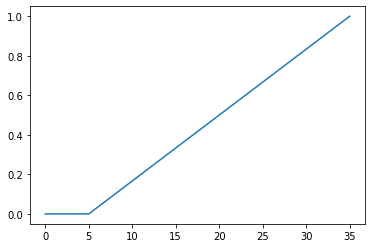

In [425]:
### var3.dict_strategy_info["baseline_strategy_data_table"]
#var4.dict_variable_info[("pib", "mix")]["max_scalar"]#ordered_trajectory_arrays[("manejo_holistico_de_gando", None)]["data"][:,-1]
#[tuple(x) for x in np.array(var4.ordered_trajectory_arrays[("pib", "mix")]["id_coordinates"])]
#var4.ordered_trajectory_arrays[("pib", "mix")]["data"][:, -5:]
y = var4.build_ramp_vector((0, 2, 1, len(var4.time_periods) - var4.time_period_end_certainty))
#y = var4.build_ramp_vector((1, 0, math.e, (len(var4.time_periods) - var4.time_period_end_certainty)/2))
x = var4.time_periods
plt.plot(x, y)
plt.show()

In [95]:
var3.ordered_trajectory_arrays[("manejo_holistico_de_gando", None)]#()


{'manejo_holistico_de_gando': array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
         0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
         0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
         0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
         0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
         0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0

In [88]:
#var4.dict_variable_info[(vs, tgs)]["uniform_scaling_q"]
#var3.dict_variable_info[("manejo_holistico_de_gando", None)]#["uniform_scaling_q"]
1 - np.array([[1, 2, 3], [2, 3, 1]])

array([[ 0, -1, -2],
       [-1, -2,  0]])

In [139]:
#dfl = pd.read_csv("/Users/jsyme/Documents/Projects/FY20/SWCHE102-1000/git/MultiSector_LTS_Chile/archive_runs/Chile_sector_package_2021_02_20_design_id-1/experimental_design_multi_sector.csv")
#list(dfl.columns)eerreeeeeee
#var1.generate_future(, baseline_future_q = True)

var1.data_table[var1.data_table["strategy_id"] == 0][fields_ext].drop_duplicates()




(False,
 {'baseline_strategy_data_table':                                  variable  \
  8      residential_apartment_acs_electric   
  4      residential_apartment_acs_electric   
  0      residential_apartment_acs_electric   
  9   residential_apartment_acs_natural_gas   
  5   residential_apartment_acs_natural_gas   
  1   residential_apartment_acs_natural_gas   
  10      residential_apartment_acs_pliqgas   
  6       residential_apartment_acs_pliqgas   
  2       residential_apartment_acs_pliqgas   
  11        residential_apartment_acs_solar   
  7         residential_apartment_acs_solar   
  3         residential_apartment_acs_solar   
  80     residential_apartment_acs_electric   
  76     residential_apartment_acs_electric   
  72     residential_apartment_acs_electric   
  81  residential_apartment_acs_natural_gas   
  77  residential_apartment_acs_natural_gas   
  73  residential_apartment_acs_natural_gas   
  82      residential_apartment_acs_pliqgas   
  78      residentia

In [76]:
#df_tmp[df_tmp["sector"] == "transport"]["variable"].unique()
#df_tmp[df_tmp["variable_trajectory_group"] == 6]["variable"]
var1.dict_id_values
var1.dict_baseline_ids

def test():
    try:
        raise Exception("this")
    except Exception as exc:
        print(exc.args)
        raise
    finally:

        print("54")
        pass

        x = 5
        print(x)
        
        return x
    
ll = test()

('this',)
54
5


In [484]:
#sampling_unit.mix_vecs(range(6), np.ones(6), [0.1, 0.1, 0.2, 0.8, 0.9, 0.99])
#var1.apply_lhs(np.array([5, 3]))
var2.apply_lhs([5, 2])

set([x[0] for x in var1.ordered_trajectory_arrays.keys()])
v1 = np.array([[1, 3, 5], [-1, 3, 1]])/4
a1 = (v1/v1.clip(*(0, 1)))#.nan_to_num(0)
a1[np.abs(a1) == np.inf] = 0
a1
#type(pyd.lhs(4, 10)[:, 0])

No trajgroup found.


<ipython-input-484-db433600a407>:7: RuntimeWarning: divide by zero encountered in true_divide
  a1 = (v1/v1.clip(*(0, 1)))#.nan_to_num(0)


array([[1.  , 1.  , 1.25],
       [0.  , 1.  , 1.  ]])

In [77]:
ss = list(var1.id_coordinates)
ss.sort()
warnings.warn("warning!")

<ipython-input-77-3d682440c941>:3: UserWarning: warning!
  warnings.warn("warning!")


In [ ]:
var1 = sampling_unit(df_tmp[df_tmp["variable_trajectory_group"] == None], {"time_series_id": 0})

In [ ]:
#var1.id_coordinates
df_prepend = df_tmp[df_tmp["variable_specification"] == "manejo_holistico_de_gando"].copy()
df_append = df_tmp[(df_tmp["variable_specification"] == "transport_truck_investment_cost_hydrogen") & (df_tmp["strategy_id"] > 0)].copy()

df_test = pd.concat([df_prepend, df_append])

In [ ]:
df_tmp[df_tmp["parameter_constant_q"].isin([1.0]) & df_tmp[""]]

In [ ]:
dict_temp = {1: "this is", 2: "this isnt", 3: "dont"}
[k for k,v in dict_temp.items() if "this" in v]

In [ ]:
sf.build_dict(df_tmp[["time_series_id", "strategy_id", "type"]])

In [ ]:
import importlib
importlib.reload(sa)

In [ ]:
(["01", "02"], [1, 2])                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   